In [11]:
import os
import json
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns



In [19]:
class COCOBloodCellDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.annotation_file = os.path.join(folder_path, "_annotations.json")
        self.transform = transform

        with open(self.annotation_file, 'r') as f:
            coco = json.load(f)

        self.image_map = {img['id']: img['file_name'] for img in coco['images']}

        self.annotations = {}
        for ann in coco['annotations']:
            img_id = ann['image_id']
            cat_id = ann['category_id']
            if img_id not in self.annotations:
                self.annotations[img_id] = cat_id

        cat_ids = sorted({cat['id'] for cat in coco['categories']})
        self.cat_id_to_label = {cat_id: idx for idx, cat_id in enumerate(cat_ids)}
        self.label_to_name = {self.cat_id_to_label[cat['id']]: cat['name'] for cat in coco['categories']}

        self.samples = [
            (self.image_map[img_id], self.cat_id_to_label[cat_id])
            for img_id, cat_id in self.annotations.items()
            if img_id in self.image_map
        ]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_name, label = self.samples[idx]
        img_path = os.path.join(self.folder_path, img_name)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image)
        return image, label


In [20]:
from torchvision import transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_dataset = COCOBloodCellDataset(r"D:\Dr. Jarez Miah_Don't delete\bloodcell_count\train", transform=transform)
val_dataset   = COCOBloodCellDataset(r"D:\Dr. Jarez Miah_Don't delete\bloodcell_count\valid", transform=transform)
test_dataset  = COCOBloodCellDataset(r"D:\Dr. Jarez Miah_Don't delete\bloodcell_count\test", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

label_names = list(train_dataset.label_to_name.values())
num_classes = len(label_names)


In [33]:
num_classes

4

In [21]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [25]:
len(train_dataset),len(test_dataset),len(val_dataset)

(255, 36, 73)

In [23]:
len(train_loader),len(test_loader),len(val_loader)

(8, 2, 3)

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=4, input_size=(224,224,3)):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)

        # Infer flatten size by forwarding a dummy input
        with torch.no_grad():
            dummy = torch.zeros(1, 3, input_size[0], input_size[1])
            x = self.pool(F.relu(self.conv1(dummy)))
            x = self.pool(F.relu(self.conv2(x)))
            self.flattened_size = x.numel()  # total number of features

        self.fc1 = nn.Linear(self.flattened_size, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


In [38]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(x)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            correct += (y_hat.argmax(1) == y).sum().item()
        acc = correct / len(train_loader.dataset)
        print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}, Train Acc: {acc:.4f}")
    
    return model



In [39]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, loader, label_names):
    model.eval()
    preds, targets = [], []
    device = next(model.parameters()).device
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            outputs = model(x).argmax(1).cpu().numpy()
            preds.extend(outputs)
            targets.extend(y.numpy())

    # Define class indices explicitly
    class_indices = list(range(len(label_names)))

    print(classification_report(targets, preds, labels=class_indices, target_names=label_names))
    
    cm = confusion_matrix(targets, preds, labels=class_indices)
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=label_names, yticklabels=label_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()


Epoch 1, Loss: 6.3207, Train Acc: 0.7961
Epoch 2, Loss: 6.1152, Train Acc: 0.7255


C:\Users\IICT1\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\IICT1\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\IICT1\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\IICT1\anaconda3\Lib\site-packages\sklearn\metrics\_cla

              precision    recall  f1-score   support

       cells       0.00      0.00      0.00         0
   Platelets       0.00      0.00      0.00         0
         RBC       0.89      1.00      0.94        32
         WBC       0.00      0.00      0.00         4

   micro avg       0.89      0.89      0.89        36
   macro avg       0.22      0.25      0.24        36
weighted avg       0.79      0.89      0.84        36



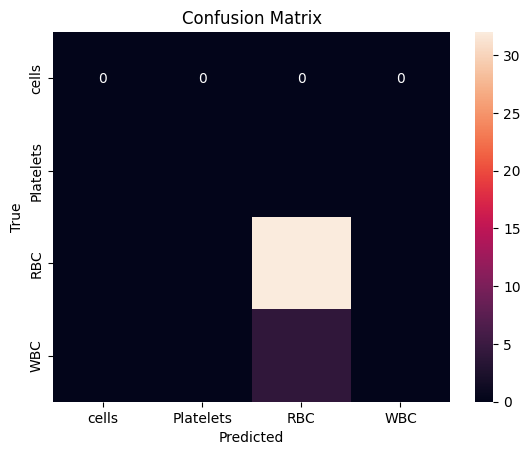

In [40]:
model = SimpleCNN(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

model = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=2)
evaluate_model(model, test_loader, label_names)


In [41]:
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, loader, label_names):
    model.eval()
    preds, targets = [], []
    device = next(model.parameters()).device
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            outputs = model(x).argmax(1).cpu().numpy()
            preds.extend(outputs)
            targets.extend(y.numpy())

    class_indices = list(range(len(label_names)))

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(targets, preds, labels=class_indices, target_names=label_names))

    # Print confusion matrix
    cm = confusion_matrix(targets, preds, labels=class_indices)
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=label_names, yticklabels=label_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    # Count number of predictions per class
    pred_counts = Counter(preds)
    true_counts = Counter(targets)

    for idx, name in enumerate(label_names):
        print(f"{name:12s} → Predicted: {pred_counts.get(idx, 0):4d} | Actual: {true_counts.get(idx, 0):4d}")


In [ ]:
evaluate_model(model, test_loader, label_names)